## Add AttnPacker to your `PYTHONPATH`

In [1]:
import os
import sys
code_root = os.path.dirname(os.path.dirname(os.getcwd()))
if code_root not in sys.path:
    print(f"Added {code_root} to python path")
    sys.path.append(code_root)
# Faster Inference on CPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['OPENBLAS_NUM_THREADS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'
os.environ['OMP_NUM_THREADS'] = '4'


Added /Users/matthewmcpartlon/VSCode/AttnPacker to python path


In [2]:
import torch
from protein_learning.models.inference_utils import (
    Inference,
    make_predicted_protein,
    default
)
import protein_learning.common.protein_constants as pc
from protein_learning.common.data.data_types.protein import safe_load_sequence, Protein
from protein_learning.models.inference_utils import format_prediction
from collections import defaultdict
from typing import List
import numpy as np
import time

In [4]:
# Helpers
def sample_seq(logits, temperature=0.1): #logits: (...,n,d)
    """Sample amino acid type from pre-residue predicted logits"""
    probs = torch.softmax(logits[...,:20]/temperature, dim=-1)
    sampled_seq = random_sample(probs)
    return "".join([pc.INDEX_TO_AA_ONE[x.item()] for x in sampled_seq]), sampled_seq

def score_seq(logits, sample, mask=None): #logits: (...,n,d)
    """Score Sequence Prediction (Lower is Better)"""
    if logits is None:
        return -1
    ce = torch.nn.CrossEntropyLoss(ignore_index=-1)
    mask = mask if mask is not None else torch.ones_like(sample,dtype=torch.bool)
    logits,sample,mask = map(lambda x: x.squeeze(),(logits,sample,mask))
    sample[~mask]=-1 #don't score unmasked positions
    return ce(logits,sample).item()

def random_sample(probs): #input: (...,n,d)
    """Get a sequence of  """
    rand = torch.rand(*probs.shape[:-1],1)
    cum_probs = torch.cumsum(probs,dim=-1)
    seles = cum_probs-rand 
    seles[seles<0] = 1
    return torch.argmin(seles,dim=-1)

def seq_sim_matrix(seqs:List[str]):
    sim = lambda s,t: sum([int(x==y) for x,y in zip(s,t)])/max(1,len(s))
    sim_mat = np.ones((len(seqs),len(seqs)))
    for i in range(len(seqs)):
        for j in range(i+1):
            sim_mat[i,j]=sim_mat[j,i]=sim(seqs[i],seqs[j])
    return sim_mat

def to_fasta_entry(pred_seq:str, prediction, uncond_logits=None, temperature=-1,name="design"):
    pred_seq_idxs = torch.tensor([pc.AA_TO_INDEX[x] for x in pred_seq])
    score = score_seq(prediction["pred_seq_logits"],pred_seq_idxs,design_mask)
    uncond_score = -1
    if uncond_logits is not None:
        uncond_score = score_seq(uncond_logits, pred_seq_idxs)
    plddt = torch.mean(prediction["pred_plddt"])
    fmt = lambda x:"{:.3f}".format(x.item() if torch.is_tensor(x) else x)
    args = map(fmt,(score,uncond_score,plddt,temperature))
    comment = ">{} score={} uncond_score={} plddt={} temp={}".format(name,*args)
    return f"{comment}\n{pred_seq}\n"

    
    

## Load Model and PDB

In [5]:
RESOURCE_ROOT = "/Users/matthewmcpartlon/Downloads/fbb_design_ft_inference/AttnPackerPTM_V2/"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
# Wrapper class for inference
runner = Inference(RESOURCE_ROOT, use_design_variant = True)
runner = runner.to(DEVICE)
model = runner.get_model()

[INFO] Initializing AttnPacker Model
[INFO] Initializing AttnPacker Model


In [75]:
pdb_path = "./pdbs/T0967.pdb"
fasta_path = None
protein = Protein.FromPDBAndSeq(
                pdb_path=pdb_path,
                seq=fasta_path,
                atom_tys=pc.ALL_ATOMS,
                missing_seq=fasta_path is None,
                load_ss=False,
            )
seq_mask = torch.ones(len(protein)).bool() # design entire backbone sequence and sidechains
dihedral_mask = None # optional mask for rotamer conditioning (defaults to all 1's i.e. no rotamer conditioning)
model_input = runner.load_example(pdb_path,seq_mask=seq_mask,dihedral_mask=dihedral_mask)
native_seq = protein.seq

## Sample from (Unconditional) Sequence and Rotamer Distribution


In [76]:
N_DESIGNS = 5
PDB_FMT_STR = None #format string for pdbs
TEMPERATURE = 0.1
VERBOSE=True
designs = []

prediction = model(model_input.to(DEVICE))
prediction = format_prediction(model,model_input,prediction)
logits = prediction["pred_seq_logits"]
for i in range(N_DESIGNS):
    pred_seq, pred_seq_idxs = sample_seq(logits,temperature=TEMPERATURE)
    designs.append(pred_seq)
    
    if VERBOSE:
        fasta_entry=to_fasta_entry(
            pred_seq, 
            prediction, 
            uncond_logits=logits, 
            name=os.path.basename(pdb_path)[:-4],
            temperature=TEMPERATURE,
        )
        print(fasta_entry)
    
    if PDB_FMT_STR is not None:
        pred_protein = make_predicted_protein(prediction["model_out"], seq = pred_seq).to("cpu")
        pred_protein.to_pdb(PDB_FMT_STR.format(i),beta=prediction["pred_plddt"])
    


>T0967 score=1.074 uncond_score=1.074 plddt=0.892 temp=0.100
SDTVTEIEAVLERLPAIVDIKKIEARRDGDILHFEIEVEVPPDITEEQGEEIKEKVTEIVKEIVKEEVEVEVELYDREK

>T0967 score=1.082 uncond_score=1.082 plddt=0.892 temp=0.100
SSVVAEIEEVLEKHPAIVDIKKIEARRDGSILHFEISVEVPPDITEEQGEEIRAKVTKIVKEIVEEEVEVEVTLYDREL

>T0967 score=1.058 uncond_score=1.058 plddt=0.892 temp=0.100
SSTVAEIEAVLEKLPAIVDIKEIEARKDGDILHFEIEVEVPPDITEEQGEEIKAEVTEIVKEIVKEETEVEVTLFDREL

>T0967 score=1.059 uncond_score=1.059 plddt=0.892 temp=0.100
SSTVAEIEAVLERLPAIVDIKEIEARKDGDVLHFEIEVEVPPDITEEQGKEIKAKVTEIVKEIVKEEVEVEVKLYDREL

>T0967 score=1.058 uncond_score=1.058 plddt=0.892 temp=0.100
SSVVAEIEAVLEKLPAIVDIKEIEARKDGDILHFEIEVEVPPDITEEQGEEIKAKVTEIVKEIVKEEVEVEVRLYDREK



### Unconditional Sampling is extremely fast, but assumes pairwise-independence of residue types. and results in to relatively low sequence diversity at lower temperatues

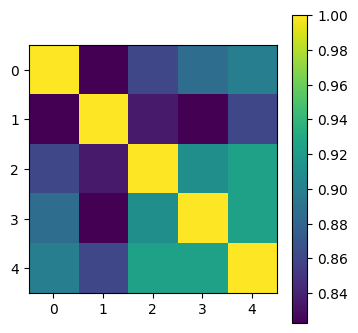

In [77]:
import matplotlib.pyplot as plt
_ = plt.figure(figsize=(4,4))
im = plt.imshow(seq_sim_matrix(designs))
plt.colorbar(im)
plt.show()

## Perform (conditional) Gibbs Sampling
- NOTE: Designs may be selected based on conditional or unconditional score and plDDT
- NOTE: It may be interesting to resample based on predicted plDDT, but this is not implemented here

In [9]:
pdb_path = "./pdbs/T0967.pdb"
fasta_path = None
protein = Protein.FromPDBAndSeq(
                pdb_path=pdb_path,
                seq=fasta_path,
                atom_tys=pc.ALL_ATOMS,
                missing_seq=fasta_path is None,
                load_ss=False,
            )
seq_mask = torch.ones(len(protein)).bool() # design entire backbone sequence and sidechains
dihedral_mask = None # optional mask for rotamer conditioning (defaults to all 1's i.e. no rotamer conditioning)
model_input = runner.load_example(pdb_path,seq_mask=seq_mask,dihedral_mask=dihedral_mask)
native_seq = protein.seq

In [23]:
# Number of Designs to generate
N_DESIGNS = 5
N_SAMPLES_PER_DESIGN = 15

#Number of positions to re-sample at each MCMC step
resample_frac = lambda step: max(0.1, 1/(2*step+1))
#Sampling Temperature to use at each step
temperature = lambda step: max(0.075,1/(2*(step+1)))

all_designs = []
final_designs = []
designs_and_scores = []

for rep in range(N_DESIGNS):
    design_mask = torch.ones(len(protein)).bool() #initial seq. mask
    dihedral_mask = None # initial dihedral mask
    pred_protein = protein # initial protein to design
    unconditional_logits = None
    fastas = []
    print(f"\n##########  Beginning Round {rep}  ##########\n")

    for step in range(N_SAMPLES_PER_DESIGN):
        model_input = runner.load_example(
            pdb_path, 
            seq_mask = design_mask, 
            dihedral_mask=dihedral_mask, 
            protein=pred_protein
        )
        prediction = model(model_input.to(DEVICE))
        prediction = format_prediction(model,model_input,prediction)
        logits = prediction["pred_seq_logits"]
        unconditional_logits = default(unconditional_logits, logits.clone())
        pred_seq, pred_seq_idxs = sample_seq(logits,temperature=temperature(step))
        #update re-sampling mask
        design_mask = torch.rand(len(protein))<resample_frac(step+1)
        #compute overall score for design
        plddt = torch.mean(prediction["pred_plddt"]).item()
        uncond_score = score_seq(unconditional_logits,pred_seq_idxs)
        total_score = (1-plddt)*uncond_score
        designs_and_scores.append((pred_seq,total_score,rep,step))
        #print fasta entry
        fasta_entry=to_fasta_entry(
            pred_seq, 
            prediction, 
            uncond_logits=unconditional_logits, 
            name=f"{os.path.basename(pdb_path)[:-4]}-{rep}-{step}",
            temperature=temperature(step),
        )
        print(fasta_entry)
        fastas.append(fasta_entry)
    
    all_designs.append(fastas)
    final_designs.append(pred_seq)
designs_and_scores = sorted(designs_and_scores,key=lambda x: x[1])


##########  Beginning Round 0  ##########

>T0967-0-0 score=1.245 uncond_score=1.245 plddt=0.892 temp=0.500
YATKARIEDRLMNLPSVVDIRSIEARRDGHIAHFKISVEVPPDVTARQGTEIRERVEEIVKSIVKDETKVSVKLYDAQE

>T0967-0-1 score=0.108 uncond_score=1.254 plddt=0.910 temp=0.250
EDYIAEIAAVLENTPSITDVKDIKARELGQVLEFEIDVYVPPDVTVEQGERIKEEVTQIVREIVEEKSTVKVKLFASQE

>T0967-0-2 score=0.103 uncond_score=1.636 plddt=0.905 temp=0.167
SEYIEAIANVLKKTPSISDVKEIEARELGMVLEFTIDLYVPPNITETTGERIKKEVNQIIKEIVDRKSTVKVRLYAAQE

>T0967-0-3 score=0.019 uncond_score=2.121 plddt=0.910 temp=0.125
EDYIEAIANVLEKTPSISDVKDIIAREVGQILEFEISLYVPPDITVWTGERIKKEVNQIIKEIVDQASKVKVKLFYAEE

>T0967-0-4 score=0.009 uncond_score=1.247 plddt=0.914 temp=0.100
EDYIAAIANVLEKHPSITDIKDIIARYLGQVLEFEIDLYVPPDITVTTGERIKKEVNQIIKEIVDRKSTVKVRLFASCE

>T0967-0-5 score=0.087 uncond_score=1.312 plddt=0.910 temp=0.083
ESYIEKIANVLEKTPSISDVKDIIARELGQVLEFEIDIYVPPDITVTTGERIKKEVNQIIKEIVDRKATVKVRLFAAQE

>T0967-0-6 score=0.029 uncond_score=0.848 plddt=0.913 temp=0.075
EDYIEAIANVLEKTP

>T0967-3-10 score=0.041 uncond_score=1.412 plddt=0.918 temp=0.075
EDYIEAIANVLEKHTSISDVKDIIARELGQVLEFEIDLYVPPDITVTTGERIKKEVNQIIKEIVDRKSTVKVRLFAAQE

>T0967-3-11 score=0.243 uncond_score=1.610 plddt=0.914 temp=0.075
SDYIEAIANVLEKTPSISDIKDIEARELGQVLEFAIDLYVPPDITVTTGERIKKEVNQIIKEIVDRKSTVKVRLFAAQE

>T0967-3-12 score=0.122 uncond_score=0.593 plddt=0.912 temp=0.075
EDYIEAIRNVLEKTPSISDIKDIKARELGQVLEFEIDLYVPPDITEETGERIKKEVNQIIKEIVDRKSTVKVRLFAAQE

>T0967-3-13 score=0.046 uncond_score=1.986 plddt=0.908 temp=0.075
EDDIEAIANVLSHTPSISDVKDIIARELGQVLEFEIRLYVPQNITVTTGERIKKEVNQIIKEIVDRKSTVKVRLFAAQE

>T0967-3-14 score=0.071 uncond_score=0.894 plddt=0.918 temp=0.075
EDSIEAIANVLEKTPSIVDVKEIIARELGQVLEFEVDLYVPPDITVTQGERIKKEVNQIIKEIVDRKSTVKVRLFAAQE


##########  Beginning Round 4  ##########

>T0967-4-0 score=1.192 uncond_score=1.192 plddt=0.892 temp=0.500
SKSVSEIKDELKEHPAVVDIKKLQASTSGDIKHFVIELEVAPDISEEQGAEIKAQVEKIVNKIVKQETRVHVRLFDRQV

>T0967-4-1 score=0.303 uncond_score=1.773 plddt=0.903 temp=0.250
EKYIKEIKNV

## Gibbs Sampling produces sequences that are more diverse, yet have similar unconditional scores

In [38]:
k=10
top_k_designs = [x[0] for x in designs_and_scores[:k]]

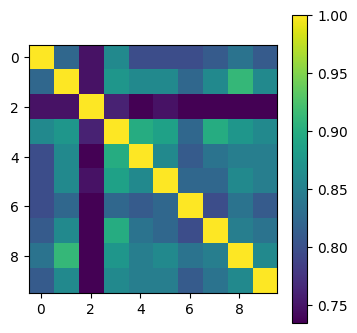

In [39]:
import matplotlib.pyplot as plt
_ = plt.figure(figsize=(4,4))
im = plt.imshow(seq_sim_matrix(top_k_designs))
plt.colorbar(im)
plt.show()